In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Handing file: test_batch
Handing file: data_batch_4
Handing file: data_batch_5
Handing file: data_batch_1
Handing file: data_batch_2
Handing file: data_batch_3


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


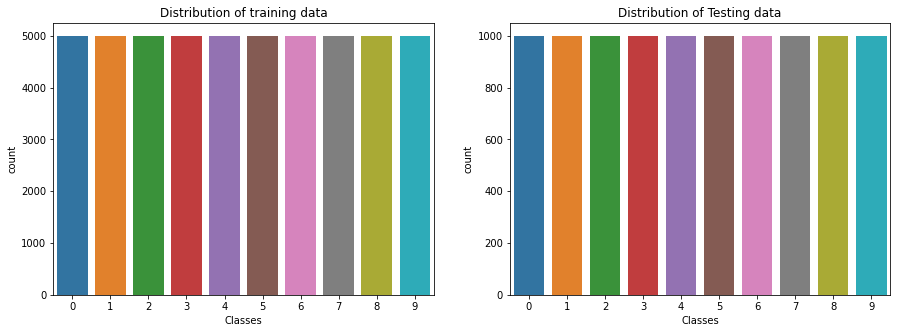

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                      

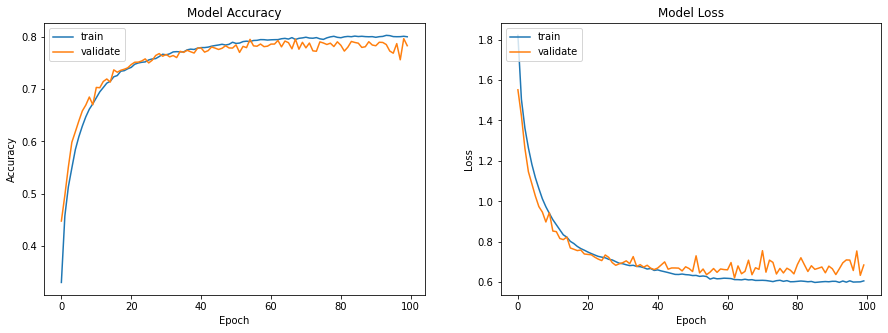

In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import pickle
import numpy as np
from os import listdir
from os.path import isfile, join
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Function to unpickle the dataset
def unpickle_all_data(directory):
    
    # Initialize the variables
    train = dict()
    test = dict()
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    # Iterate through all files that we want, train and test
    # Train is separated into batches
    for filename in listdir(directory):
        if isfile(join(directory, filename)):
            
            # The train data
            if 'data_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Opent the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')

                if 'data' not in train:
                    train['data'] = data[b'data']
                    train['labels'] = np.array(data[b'labels'])
                else:
                    train['data'] = np.concatenate((train['data'], data[b'data']))
                    train['labels'] = np.concatenate((train['labels'], data[b'labels']))
            # The test data
            elif 'test_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Open the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo, encoding='bytes')
                
                test['data'] = data[b'data']
                test['labels'] = data[b'labels']
    
    # Manipulate the data to the propper format
    for image in train['data']:
        train_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    train_y = [label for label in train['labels']]
    
    for image in test['data']:
        test_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    test_y = [label for label in test['labels']]
    
    # Transform the data to np array format
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    return (train_x, train_y), (test_x, test_y)

# Run the function with and include the folder where the data are
(x_train, y_train), (x_test, y_test) = unpickle_all_data("/content/cifar-10-batches-py")

batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              
              metrics=['accuracy'])


history = None  # For recording the history of trainning process.

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
          
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:

    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)
